In [70]:
import ee
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from radiant_mlhub import Dataset

In [2]:
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWhrV4gxjuJN1dPbzj4QvuelbQmKut-5UHZmL-Ud8lpH2qlJrUSfkbA

Successfully saved authorization token.


In [3]:
# Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap", zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
        if ee.image.Image in [type(x) for x in v.values()]:
            folium.TileLayer(
                tiles = v["tile_fetcher"].url_format,
                attr  = 'Google Earth Engine',
                overlay =True,
                name  = k
              ).add_to(mapViz)
        else:
            folium.GeoJson(
            data = v,
            name = k
              ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

## Classification with Random Forest

The `Classifier` package handles supervised classification in Earth Engine and the general workflow for classification is:

1. Collect training data. Assemble features which have a property that stores the known class label and properties storing numeric values for the predictors.

2. Instantiate a classifier. Set its parameters if necessary.
3. Train the classifier using the training data.
4. Classify an image or feature collection.
5. Estimate classification error with independent test data.

- The training data is a `FeatureCollection` with a property storing the class label and properties storing predictor variables.
- Class labels should be consecutive, integers starting from 0. If necessary, use `remap()` to convert class values to consecutive integers. The predictors should be numeric.
- Training and/or testing data can come from a variety of sources. 
- To collect training data interactively in Earth Engine, you can use the geometry drawing tools (see the [Code Editor section](https://developers.google.com/earth-engine/playground)). 
- Alternatively, you can import predefined training data from an Earth Engine table asset or a Fusion Table (see the [Importing section](https://developers.google.com/earth-engine/importing) for details). 
- Get a classifier from one of the constructors in `ee.Classifier`. Train the classifier using `classifier.train()`. Classify an `Image` or `FeatureCollection` using `classify()`.

We use random forest classifier with 10 trees to downscale MODIS data to Landsat resolution. The `sample()` method generates two random samples from the MODIS data: one for training and one for test. The training sample is used to train the classifier. You can get resubstitution accuracy on the training data from `classifier.confusionMatrix()`. To get test accuracy, classify the test data. This adds a `classification` property to the test `FeatureCollection`. Call `errorMatrix()` on the classified `FeatureCollection` to get a confusion matrix representing test (expected) accuracy.

In [180]:
# geojson = {
#   "type": "FeatureCollection",
#   "features": [
#     {
#       "type": "Feature",
#       "properties": {},
#       "geometry": {
#         "type": "Polygon",
#         "coordinates": [
#           [
#             [
#               34.73876953125,
#               -13.432366575813747
#             ],
#             [
#               36.826171875,
#               -13.432366575813747
#             ],
#             [
#               36.826171875,
#               -11.802834233547674
#             ],
#             [
#               34.73876953125,
#               -11.802834233547674
#             ],
#             [
#               34.73876953125,
#               -13.432366575813747
#             ]
#           ]
#         ]
#       }
#     }
#   ]
# }

In [ ]:
geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Point",
        "coordinates": [
          36.76025390625,
          -13.304102866767076
        ]
      }
    }
  ]
}

In [182]:
# Define a region of interest as a rectangle.  Change the coordinates
# to get a classification of any place where there is imagery.
coords = geojson['features'][0]['geometry']['coordinates']
AOI = ee.Geometry.Polygon(coords)

# Chosen bands 
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11']


# Load Landsat 5 input imagery.
# 1. Filter to get only one year of images.
# 2. Filter to get only images under the region of interest.
# 3. Sort by scene cloudiness, ascending.
# 4. Get the first (least cloudy) scene.
# 5. Select 7 bands (fron 1 to 7)
landsat = ee.Image(ee.ImageCollection("LANDSAT/LC08/C01/T1_RT_TOA")\
                   .filterDate('2020-09-01', '2021-09-30')\
                   .filterBounds(AOI)\
                   .sort('CLOUD_COVER')\
                   .first()\
                   .select(bands))

# Compute cloud score.
cloudScore = ee.Algorithms.Landsat.simpleCloudScore(landsat).select('cloud')

# Mask the input for clouds.  Compute the min of the input mask to mask
# pixels where any band is masked.  Combine that with the cloud mask.
Input = landsat.updateMask(landsat.mask().reduce('min').And(cloudScore.lte(90)))

# Use MODIS land cover, IGBP (International Geosphere-Biosphere Programme) classification, for training.
# This data set is one of the products of the International Satellite Land-Surface Climatology Project, 
# Initiative II (ISLSCP II) data collection.
modis = ee.Image('MODIS/051/MCD12Q1/2013_01_01').select('Land_Cover_Type_1')

# Sample the input imagery to get a FeatureCollection of training data.
# Get the values for all pixels in each polygon in the training.
training = Input.addBands(modis).sample(numPixels=5000, seed=0)
print(f"The number of total images is : {training.size().getInfo()}")
print()


# The randomColumn() method will add a column of uniform random
# numbers in a column named 'random' by default.
sample = training.randomColumn()

# Roughly 70% training, 30% testing.
split = 0.7  
trainingPartition = sample.filter(ee.Filter.lt('random', split))
testingPartition = sample.filter(ee.Filter.gte('random', split))

# Make a Random Forest classifier and train it.
trainedclassifier = ee.Classifier.smileRandomForest(10).train(trainingPartition, 'Land_Cover_Type_1', inputProperties=bands)

# Classify the input imagery.
classified = Input.classify(trainedclassifier)

# Get a confusion matrix representing resubstitution accuracy.
trainAccuracy = trainedclassifier.confusionMatrix()

# train confusion matrix into pandas
trainConfusionMat = pd.DataFrame(np.asarray(trainAccuracy.getInfo()))

print(f"The number of images for training Partition is : {trainingPartition.size().getInfo()}")
print()
print(f"Resubstitution error matrix : {trainAccuracy.getInfo()}")
print()
print(f"Training accuracy is : {100 *  trainAccuracy.accuracy().getInfo():.2f} %")
print()


# Classify the testing data.
tested = testingPartition.classify(trainedclassifier)

# Get a confusion matrix representing expected accuracy.
testAccuracy = tested.errorMatrix('Land_Cover_Type_1', 'classification')

# test error matrix into pandas
testErrorMat = pd.DataFrame(np.asarray(testAccuracy.getInfo()))

print(f"The number of images for test Partition is : {testingPartition.size().getInfo()}")
print()
print(f"Test error matrix : {testAccuracy.getInfo()}")
print()
print(f"Test accuracy is : {100 * testAccuracy.accuracy().getInfo():.2f} %")

# Define a palette for the IGBP classification.
igbpPalette = [
    'blue', # water
    'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', # forest
    'gray', 'gray', 'gray', 'gray', 'gray',  # shrub, grass
    'maroon', # wetlands
    'green', # croplands
    'yellow', # urban
    'black', # crop mosaic
    'chocolate', # snow and ice
    'cyan', # barren
    'darkorange'  # tundra
]

# Display the input and the classification.
Input_token = Input.getMapId({'bands': ['B5', 'B4'], 'max': 0.5}) # B5=NIR B4=Red
classified_token = classified.getMapId({'palette': igbpPalette, 'min': 0, 'max': 17})
center = [-12.57, 35.52]
Mapdisplay(center, {'Landsat':Input_token,'LandUse':classified_token}, zoom_start=8)

The number of total images is : 4887

The number of images for training Partition is : 3382

Resubstitution error matrix : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 23, 0, 0, 6, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2001, 26, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 129, 1128, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 12, 8, 0, 0, 0, 0, 38]]

Training accuracy is : 94.59 %

The number of images for test Partition is : 1505

Test error matrix : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 

The accuracy estimated from training data is an overestimate because the random forest is "fit" to the training data. The expected accuracy on unknown data is a too lower, as indicated by the estimate from the test data.

In [170]:
print(type(trainAccuracy.getInfo()))
print(cloudScore.getInfo()['bands'])

<class 'list'>
[{'id': 'cloud', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 100}, 'dimensions': [7601, 7731], 'crs': 'EPSG:32637', 'crs_transform': [30, 0, 243585, 0, -30, -1323285]}]


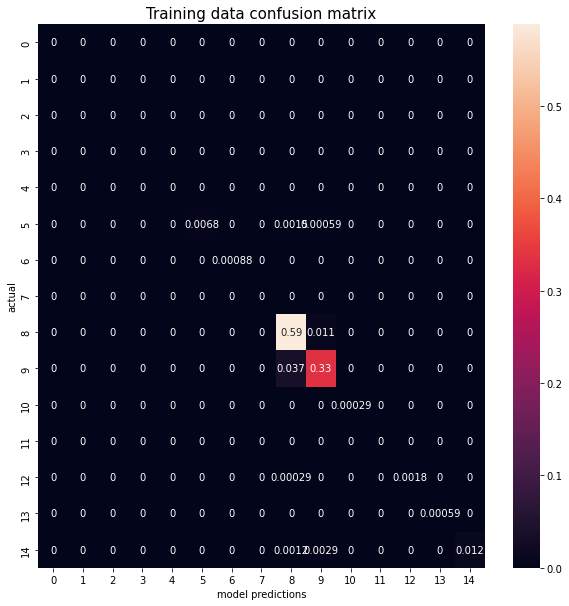

In [171]:
trainCM_L8 = trainConfusionMat/trainingPartition.size().getInfo()

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(trainCM_L8, annot=True)
ax.set_xlabel('model predictions', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
plt.title("Training data confusion matrix", fontsize=15);

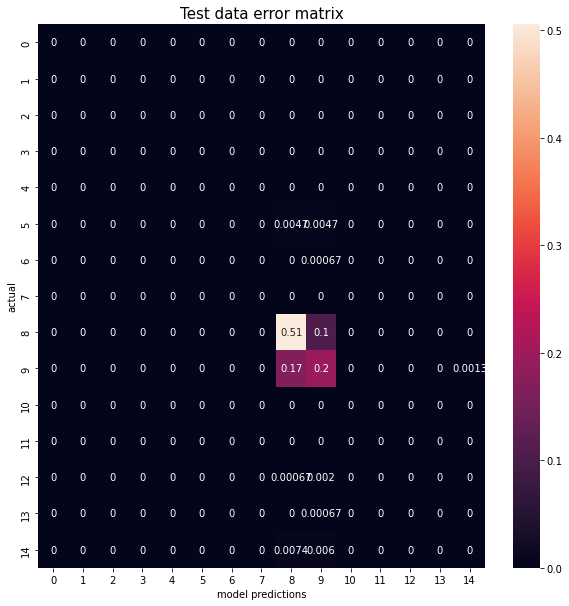

In [172]:
testEM_L8 = testErrorMat/testingPartition.size().getInfo()

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(testEM_L8, annot=True)
ax.set_xlabel('model predictions', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
plt.title("Test data error matrix", fontsize=15);

In [173]:
# Define a region of interest as a rectangle.  Change the coordinates
# to get a classification of any place where there is imagery.
coords = geojson['features'][0]['geometry']['coordinates']
AOI = ee.Geometry.Polygon(coords)

# Chosen bands 
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11']


# Load Landsat 5 input imagery.
# 1. Filter to get only one year of images.
# 2. Filter to get only images under the region of interest.
# 3. Sort by scene cloudiness, ascending.
# 4. Get the first (least cloudy) scene.
# 5. Select 7 bands (fron 1 to 7)
landsat = ee.Image(ee.ImageCollection("LANDSAT/LC08/C01/T1_RT_TOA")\
                   .filterDate('2020-09-01', '2021-09-30')\
                   .filterBounds(AOI)\
                   .sort('CLOUD_COVER')\
                   .first()\
                   .select(bands))

# Compute cloud score.
cloudScore = ee.Algorithms.Landsat.simpleCloudScore(landsat).select('cloud')

# Mask the input for clouds.  Compute the min of the input mask to mask
# pixels where any band is masked.  Combine that with the cloud mask.
Input = landsat.updateMask(landsat.mask().reduce('min').And(cloudScore.lte(90)))

# Use MODIS land cover, IGBP (International Geosphere-Biosphere Programme) classification, for training.
# This data set is one of the products of the International Satellite Land-Surface Climatology Project, 
# Initiative II (ISLSCP II) data collection.
modis = ee.Image('MODIS/051/MCD12Q1/2013_01_01').select('Land_Cover_Type_1')

# Sample the input imagery to get a FeatureCollection of training data.
# Get the values for all pixels in each polygon in the training.
training = Input.addBands(modis).sample(numPixels=5000, seed=0)
print(f"The number of total images is : {training.size().getInfo()}")
print()


# The randomColumn() method will add a column of uniform random
# numbers in a column named 'random' by default.
sample = training.randomColumn()

# Roughly 70% training, 30% testing.
split = 0.7  
trainingPartition = sample.filter(ee.Filter.lt('random', split))
testingPartition = sample.filter(ee.Filter.gte('random', split))

# Make a Random Forest classifier and train it.
trainedclassifier = ee.Classifier.smileRandomForest(20).train(trainingPartition, 'Land_Cover_Type_1', inputProperties=bands)

# Classify the input imagery.
classified = Input.classify(trainedclassifier)

# Get a confusion matrix representing resubstitution accuracy.
trainAccuracy = trainedclassifier.confusionMatrix()

# train confusion matrix into pandas
trainConfusionMat = pd.DataFrame(np.asarray(trainAccuracy.getInfo()))

print(f"The number of images for training Partition is : {trainingPartition.size().getInfo()}")
print()
print(f"Resubstitution error matrix : {trainAccuracy.getInfo()}")
print()
print(f"Training accuracy is : {100 *  trainAccuracy.accuracy().getInfo():.2f} %")
print()


# Classify the testing data.
tested = testingPartition.classify(trainedclassifier)

# Get a confusion matrix representing expected accuracy.
testAccuracy = tested.errorMatrix('Land_Cover_Type_1', 'classification')

# test error matrix into pandas
testErrorMat = pd.DataFrame(np.asarray(testAccuracy.getInfo()))

print(f"The number of images for test Partition is : {testingPartition.size().getInfo()}")
print()
print(f"Test error matrix : {testAccuracy.getInfo()}")
print()
print(f"Test accuracy is : {100 * testAccuracy.accuracy().getInfo():.2f} %")

# Define a palette for the IGBP classification.
igbpPalette = [
    'blue', # water
    'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', # forest
    'gray', 'gray', 'gray', 'gray', 'gray',  # shrub, grass
    'maroon', # wetlands
    'green', # croplands
    'yellow', # urban
    'black', # crop mosaic
    'chocolate', # snow and ice
    'cyan', # barren
    'darkorange'  # tundra
]

# Display the input and the classification.
Input_token = Input.getMapId({'bands': ['B5', 'B4'], 'max': 0.5}) # B5=NIR B4=Red
classified_token = classified.getMapId({'palette': igbpPalette, 'min': 0, 'max': 17})
center = [-12.57, 35.52]
Mapdisplay(center, {'Landsat':Input_token,'LandUse':classified_token}, zoom_start=8)

The number of total images is : 4887

The number of images for training Partition is : 3392

Resubstitution error matrix : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 28, 0, 0, 1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2018, 15, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 60, 1201, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 0, 0, 0, 0, 43]]

Training accuracy is : 97.38 %

The number of images for test Partition is : 1495

Test error matrix : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0,

When we increase the number of trees and the cloud score, our model perform better but still poor.

In [179]:
# Define a region of interest as a rectangle.  Change the coordinates
# to get a classification of any place where there is imagery.
coords = geojson['features'][0]['geometry']['coordinates']
AOI = ee.Geometry.Polygon(coords)

# Chosen bands 
bands = [ 'B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Load Landsat 5 input imagery.
# 1. Filter to get only one year of images.
# 2. Filter to get only images under the region of interest.
# 3. Sort by scene cloudiness, ascending.
# 4. Get the first (least cloudy) scene.
# 5. Select 7 bands (fron 1 to 7)
landsat = ee.Image(ee.ImageCollection('LANDSAT/LT05/C01/T1_TOA')\
                    .filterDate('2011-01-01', '2020-12-31')\
                    .filterBounds(AOI)\
                    .sort('CLOUD_COVER')\
                    .first()\
                    .select(bands))


# Compute cloud score.
cloudScore = ee.Algorithms.Landsat.simpleCloudScore(landsat).select('cloud')

# Mask the input for clouds.  Compute the min of the input mask to mask
# pixels where any band is masked.  Combine that with the cloud mask.
Input = landsat.updateMask(landsat.mask().reduce('min').And(cloudScore.lte(90)))

# Use MODIS land cover, IGBP (International Geosphere-Biosphere Programme) classification, for training.
# This data set is one of the products of the International Satellite Land-Surface Climatology Project, 
# Initiative II (ISLSCP II) data collection.
modis = ee.Image('MODIS/051/MCD12Q1/2013_01_01').select('Land_Cover_Type_1')

# Sample the input imagery to get a FeatureCollection of training data.
# Get the values for all pixels in each polygon in the training.
training = Input.addBands(modis).sample(numPixels=5000, seed=0)
print(f"The number of total images is : {training.size().getInfo()}")
print()


# The randomColumn() method will add a column of uniform random
# numbers in a column named 'random' by default.
sample = training.randomColumn()

# Roughly 70% training, 30% testing.
split = 0.7  
trainingPartition = sample.filter(ee.Filter.lt('random', split))
testingPartition = sample.filter(ee.Filter.gte('random', split))

# Make a Random Forest classifier and train it.
trainedclassifier = ee.Classifier.smileRandomForest(10).train(trainingPartition, 'Land_Cover_Type_1', inputProperties=bands)

# Classify the input imagery.
classified = Input.classify(trainedclassifier)

# Get a confusion matrix representing resubstitution accuracy.
trainAccuracy = trainedclassifier.confusionMatrix()

# train confusion matrix into pandas
trainConfusionMat = pd.DataFrame(np.asarray(trainAccuracy.getInfo()))

print(f"The number of images for training Partition is : {trainingPartition.size().getInfo()}")
print()
print(f"Resubstitution error matrix : {trainAccuracy.getInfo()}")
print()
print(f"Training accuracy is : {100 *  trainAccuracy.accuracy().getInfo():.2f} %")
print()


# Classify the testing data.
tested = testingPartition.classify(trainedclassifier)

# Get a confusion matrix representing expected accuracy.
testAccuracy = tested.errorMatrix('Land_Cover_Type_1', 'classification')

# test error matrix into pandas
testErrorMat = pd.DataFrame(np.asarray(testAccuracy.getInfo()))

print(f"The number of images for test Partition is : {testingPartition.size().getInfo()}")
print()
print(f"Test error matrix : {testAccuracy.getInfo()}")
print()
print(f"Test accuracy is : {100 * testAccuracy.accuracy().getInfo():.2f} %")

# Define a palette for the IGBP classification.
igbpPalette = [
    'blue', # water
    'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', # forest
    'gray', 'gray', 'gray', 'gray', 'gray',  # shrub, grass
    'maroon', # wetlands
    'green', # croplands
    'yellow', # urban
    'black', # crop mosaic
    'chocolate', # snow and ice
    'cyan', # barren
    'darkorange'  # tundra
]

# Display the input and the classification.
Input_token = Input.getMapId({'bands': ['B4', 'B3'], 'max': 0.5}) # B4=NIR B3=Red
classified_token = classified.getMapId({'palette': igbpPalette, 'min': 0, 'max': 17})
center = [-12.57, 35.52]
Mapdisplay(center, {'Landsat':Input_token,'LandUse':classified_token}, zoom_start=8)

The number of total images is : 4643

The number of images for training Partition is : 3239

Resubstitution error matrix : [[935, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 49, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 1385, 5, 0, 0, 0, 0, 3, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 42, 538, 0, 0, 0, 0, 3, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 8, 0, 0, 0, 0, 0, 0], [8, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 14, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 15, 0, 2, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 21, 25, 0, 0, 0, 0, 129, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [5, 0, 0, 0,

The accuracy estimated from training data is an overestimate because the random forest is “fit” to the training data. The expected accuracy on unknown data is a bit lower (which is more better than the last one), as indicated by the estimate from the test data.

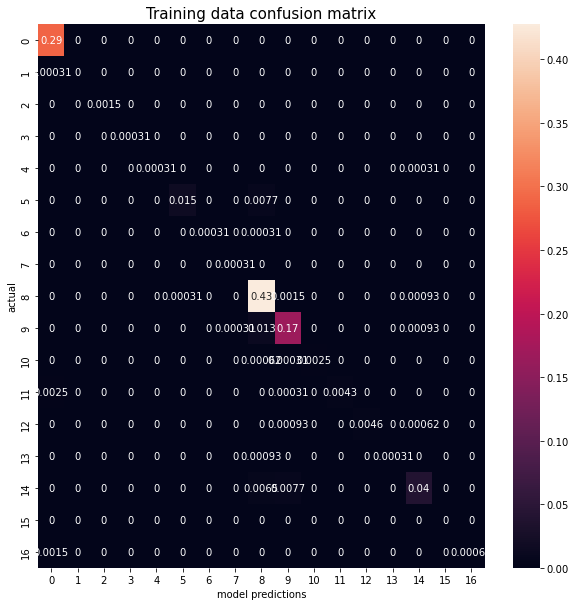

In [175]:
trainCM_L5 = trainConfusionMat/trainingPartition.size().getInfo()

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(trainCM_L5, annot=True)
ax.set_xlabel('model predictions', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
plt.title("Training data confusion matrix", fontsize=15);

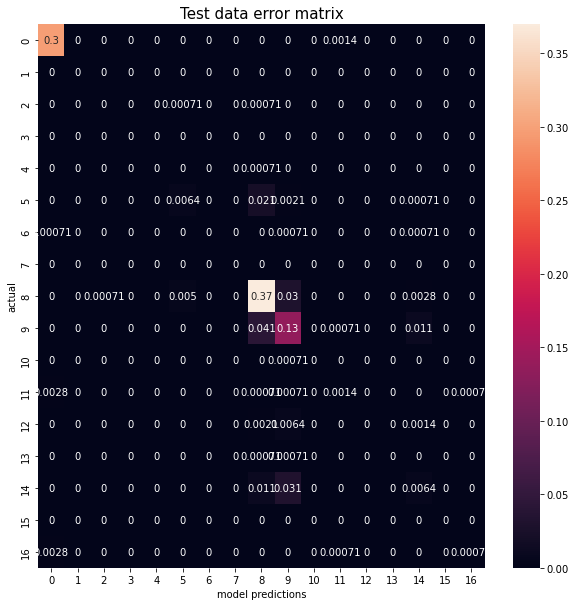

In [176]:
testEM_L5 = testErrorMat/testingPartition.size().getInfo()

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(testEM_L5, annot=True)
ax.set_xlabel('model predictions', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
plt.title("Test data error matrix", fontsize=15);

In [231]:
# Define a region of interest as a point.  Change the coordinates
# to get a classification of any place where there is imagery.
coords = geojson['features'][0]['geometry']['coordinates']
AOI = ee.Geometry.Point(coords)

# Chosen bands
bands = [ 'B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Load Landsat 5 input imagery.
# 1. Filter to get only one year of images.
# 2. Filter to get only images under the region of interest.
# 3. Sort by scene cloudiness, ascending.
# 4. Get the first (least cloudy) scene.
# 5. Select 7 bands (fron 1 to 7)
landsat = ee.Image(ee.ImageCollection('LANDSAT/LT05/C01/T1_TOA')\
                    .filterDate('2011-01-01', '2020-12-31')\
                    .filterBounds(AOI)\
                    .sort('CLOUD_COVER')\
                    .first()\
                    .select(bands))


# Compute cloud score.
cloudScore = ee.Algorithms.Landsat.simpleCloudScore(landsat).select('cloud')

# Mask the input for clouds.  Compute the min of the input mask to mask
# pixels where any band is masked.  Combine that with the cloud mask.
Input = landsat.updateMask(landsat.mask().reduce('min').And(cloudScore.lte(90)))

# Use MODIS land cover, IGBP (International Geosphere-Biosphere Programme) classification, for training.
# This data set is one of the products of the International Satellite Land-Surface Climatology Project, 
# Initiative II (ISLSCP II) data collection.
modis = ee.Image('MODIS/051/MCD12Q1/2013_01_01').select('Land_Cover_Type_1')


# Sample the input imagery to get a FeatureCollection of training data.
# Get the values for all pixels in each polygon in the training.
training = Input.addBands(modis).sample(numPixels=5000, seed=0)
print(f"The number of total images is : {training.size().getInfo()}")
print()


# The randomColumn() method will add a column of uniform random
# numbers in a column named 'random' by default.
sample = training.randomColumn()

# Roughly 70% training, 30% testing.
split = 0.7  
trainingPartition = sample.filter(ee.Filter.lt('random', split))
testingPartition = sample.filter(ee.Filter.gte('random', split))

# Make a Random Forest classifier and train it.
trainedclassifier = ee.Classifier.smileRandomForest(20).train(trainingPartition, 'Land_Cover_Type_1', inputProperties=bands)

# Classify the input imagery.
classified = Input.classify(trainedclassifier)

# Get a confusion matrix representing resubstitution accuracy.
trainAccuracy = trainedclassifier.confusionMatrix()

# train confusion matrix into pandas
trainConfusionMat = pd.DataFrame(np.asarray(trainAccuracy.getInfo()))

print(f"The number of images for training Partition is : {trainingPartition.size().getInfo()}")
print()
print(f"Resubstitution error matrix : {trainAccuracy.getInfo()}")
print()
print(f"Training accuracy is : {100 *  trainAccuracy.accuracy().getInfo():.2f} %")
print()


# Classify the testing data.
tested = testingPartition.classify(trainedclassifier)

# Get a confusion matrix representing expected accuracy.
testAccuracy = tested.errorMatrix('Land_Cover_Type_1', 'classification')

# test error matrix into pandas
testErrorMat = pd.DataFrame(np.asarray(testAccuracy.getInfo()))

print(f"The number of images for test Partition is : {testingPartition.size().getInfo()}")
print()
print(f"Test error matrix : {testAccuracy.getInfo()}")
print()
print(f"Test accuracy is : {100 * testAccuracy.accuracy().getInfo():.2f} %")

# # Define a palette for the IGBP classification.
# igbpPalette = [
#   'blue', # water
#   '152106', '225129', '369b47', '30eb5b', '387242', # forest
#   '6a2325', 'c3aa69', 'b76031', 'd9903d', '91af40',  # shrub, grass
#   '111149', # wetlands
#   'cdb33b', # croplands
#   'cc0013', # urban
#   '33280d', # crop mosaic
#   'd7cdcc', # snow and ice
#   'f7e084', # barren
#   '6f6f6f'  # tundra
# ]

igbpPalette = [
    'blue', # water
    'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', # forest
    'gray', 'gray', 'gray', 'gray', 'gray',  # shrub, grass
    'maroon', # wetlands
    'green', # croplands
    'yellow', # urban
    'black', # crop mosaic
    'chocolate', # snow and ice
    'cyan', # barren
    'darkorange'  # tundra
]

# # Display the input and the classification.
# Input_token = Input.getMapId({'bands': ['B4', 'B3'], 'max': 0.5}) # B4=NIR B3=Red
# classified_token = classified.getMapId({'palette': igbpPalette, 'min': 0, 'max': 17})
# center = [-12.57, 35.52]
# Mapdisplay(center, {'Landsat':Input_token,'LandUse':classified_token}, zoom_start=8)

# Display the input and the classification.
map1.centerObject(AOI, 8)
map1.addLayer(Input, {'bands': ['B3', 'B2', 'B1'], 'max': 0.4}, 'landsat')
map1.addLayer(classified, {'palette': igbpPalette, 'min': 0, 'max': 17}, 'classification')


# Add legend
legend_keys = ['water', 'forest', 'forest', 'forest', 'forest', 'forest', 'shrub, grass', 
               'shrub, grass', 'shrub, grass', 'shrub , grass', 'shrub , grass', 'wetlands', 
               'croplands', 'urban', 'crop mosaic', 'snow and ice', 'barren', 'tundra']

# legend_colors = ['blue', '152106', '225129', '369b47', '30eb5b', '387242', '6a2325', 
#                  'c3aa69', 'b76031', 'd9903d', '91af40', '111149', 'cdb33b', 'cc0013',
#                  '33280d', 'd7cdcc', 'f7e084', '6f6f6f']
legend_colors = ['blue', '152106', '225129', '369b47', '30eb5b', '387242', '6a2325', 
                 'c3aa69', 'b76031', 'd9903d', '91af40', '111149', 'cdb33b', 'cc0013',
                 '33280d', 'd7cdcc', 'f7e084', '6f6f6f']
# legend_colors = ['blue', 'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', 'gray', 
#                  'gray', 'gray', 'gray', 'gray', 'maroon', 'green', 'yellow',
#                  'black', 'chocolate', 'cyan', 'darkorange']


# Classify the input imagery.
classified = classified.remap([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

map1.addLayer(classified, {'min': 0, 'max': 17, 'palette': legend_colors}, 'Labelled clusters')
map1.add_legend(legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright')

The number of total images is : 4587

The number of images for training Partition is : 3166

Resubstitution error matrix : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 30, 0, 0, 33, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 3051, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 33, 2, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1]]

Training accuracy is : 97.60 %

The number of images for test Partition is : 1421

Test error matrix : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 

When the number of trees increases and the cloud score, our model perform better but still not very good.

In [218]:
map1

Map(bottom=140805.09088134766, center=[-12.6187616422214, 35.78247070312495], controls=(WidgetControl(options=…

In [183]:
import pandas as pd

In [186]:
path_train = 'C:/Users/engelbert/Downloads/Ishango/Notebook/Landsat_8_data/Landsat/Dataset/training.csv'
path_test = 'C:/Users/engelbert/Downloads/Ishango/Notebook/Landsat_8_data/Landsat/Dataset/testing.csv'

df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

In [187]:
df_train

,max_ndvi,20150720_N,20150602_N,20150517_N,20150501_N,20150415_N,20150330_N,20150314_N,20150226_N,20150210_N,...,20140525_N,20140509_N,20140423_N,20140407_N,20140322_N,20140218_N,20140202_N,20140117_N,20140101_N,LULC_class
0,997.904,637.5950,658.668,-1882.030,-1924.36,997.904,-1739.990,630.087,-1628.240,-1325.64,...,-1043.160,-1942.490,267.138,366.608,452.238,211.328,-2203.02,-1180.190,433.906,water
1,914.198,634.2400,593.705,-1625.790,-1672.32,914.198,-692.386,707.626,-1670.590,-1408.64,...,-933.934,-625.385,120.059,364.858,476.972,220.878,-2250.00,-1360.560,524.075,water
2,3800.810,1671.3400,1206.880,449.735,1071.21,546.371,1077.840,214.564,849.599,1283.63,...,1566.160,2208.440,1056.600,385.203,300.560,293.730,2762.57,150.931,3800.810,water
3,952.178,58.0174,-1599.160,210.714,-1052.63,578.807,-1564.630,-858.390,729.790,-3162.14,...,368.622,-1786.950,-1227.800,304.621,291.336,369.214,-2202.12,600.359,-1343.550,water
4,1232.120,72.5180,-1220.880,380.436,-1256.93,515.805,-1413.180,-802.942,683.254,-2829.40,...,155.624,-1189.710,-924.073,432.150,282.833,298.320,-2197.36,626.379,-826.727,water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10540,7579.580,6072.5000,3803.140,3902.220,3897.43,3767.050,3985.770,4122.540,4240.230,5240.53,...,5513.730,1538.240,3507.360,1099.800,461.336,406.031,4652.03,2774.980,500.864,impervious
10541,2780.930,1895.6800,1454.740,1265.480,1033.56,1930.380,1057.150,1471.600,1427.340,2693.63,...,2093.020,1232.110,1190.830,1441.460,1170.880,1095.000,1818.65,2501.720,1247.770,impervious
10542,5833.760,3465.7400,1283.320,413.412,4391.05,1146.820,4473.050,1614.750,770.469,2886.59,...,4047.320,4515.800,433.177,277.296,744.143,315.503,3759.71,3267.170,388.346,impervious
10543,3079.310,2435.3000,1444.400,1133.760,1278.74,927.765,1917.040,1514.920,1685.130,1644.49,...,2050.940,1848.100,1725.820,1935.410,2089.710,668.160,1880.59,1614.840,1518.980,impervious


In [188]:
df_test

,max_ndvi,20150720_N,20150602_N,20150517_N,20150501_N,20150415_N,20150330_N,20150314_N,20150226_N,20150210_N,...,20140525_N,20140509_N,20140423_N,20140407_N,20140322_N,20140218_N,20140202_N,20140117_N,20140101_N,LULC_class
0,2750.110,1361.8900,-247.508,-521.17300,-1123.910,2653.0800,-264.4140,-456.4660,2080.85000,-2041.430,...,1078.400,1778.030,2673.610,-178.9710,2238.5800,1000.760,-81.5418,1146.260,-1566.490,water
1,2646.250,1760.8500,481.100,6.26571,398.950,2646.2500,550.9820,92.6923,2188.03000,-1049.050,...,1083.700,2029.520,1033.900,-19.6148,2183.6600,927.882,668.7500,1519.740,-568.973,water
2,3509.620,3509.6200,-241.320,-1239.32000,-330.388,1257.1900,-175.1710,-294.5000,-1315.06000,2486.500,...,1538.750,846.783,965.654,-468.0240,-222.3120,1124.250,1132.9000,594.059,-993.658,water
3,2820.470,2138.6900,-126.186,-522.28100,-741.163,2334.7000,-207.4360,-76.9686,2820.47000,-1427.560,...,984.456,2239.330,593.874,1540.8800,2398.4200,846.470,572.3080,1311.610,-1396.500,water
4,2684.130,1995.8000,-1029.570,1713.62000,-472.258,2526.9900,-91.7429,-146.2260,2487.71000,1185.190,...,1432.150,2174.890,1321.690,1351.5800,2381.9500,870.890,1174.3300,991.427,-185.322,water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,491.678,-1673.7400,-2514.480,-2451.19000,-2738.440,64.4464,-2275.0300,-2881.1000,-4738.97000,-4293.570,...,-2582.420,-1699.100,-2295.300,306.4830,209.4030,221.920,-4885.1500,-2630.590,356.233,water
296,556.093,-96.8233,-412.727,-1795.40000,-2363.820,-2168.1900,-2162.6800,-3155.7400,-4416.11000,-5648.660,...,-2614.910,-2109.840,-2687.180,-2853.8900,71.3402,-86.414,-5109.0100,324.637,-4316.580,water
297,987.461,-2364.6000,-155.592,-1422.09000,-1713.400,465.6220,-2230.4000,-3088.7300,-5010.32000,-4211.420,...,-1756.080,-3820.430,-1988.230,433.8520,291.8000,254.548,-4259.3000,412.115,-1170.750,water
298,973.953,-3004.6300,-1217.120,180.12200,-1113.890,438.4180,-2442.5100,-3210.5600,-3237.74000,-192.857,...,-2018.450,-3472.650,-3109.070,511.7920,369.0970,276.948,-5574.5100,298.739,460.419,water


In [197]:
modis.getInfo()

{'type': 'Image',
 'bands': [{'id': 'Land_Cover_Type_1',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'dimensions': [86400, 43200],
   'crs': 'SR-ORG:6974',
   'crs_transform': [463.3127165279165,
    0,
    -20015109.353988,
    0,
    -463.3127165274999,
    10007554.676994]}],
 'id': 'MODIS/051/MCD12Q1/2013_01_01',
 'version': 1507159858527813,
 'properties': {'Land_Cover_Type_4_class_names': ['Water',
   'Evergreen Needleleaf vegetation',
   'Evergreen Broadleaf vegetation',
   'Deciduous Needleleaf vegetation',
   'Deciduous Broadleaf vegetation',
   'Annual Broadleaf vegetation',
   'Annual grass vegetation',
   'Non-vegetated land',
   'Urban',
   'Unclassified'],
  'Land_Cover_Type_5_class_names': ['Water',
   'Evergreen Needleleaf trees',
   'Evergreen Broadleaf trees',
   'Deciduous Needleleaf trees',
   'Deciduous Broadleaf trees',
   'Shrub',
   'Grass',
   'Cereal crops',
   'Broad-leaf crops',
   'Urban and built-up',
   

In [198]:
type(modis.getInfo())

dict

In [204]:
len(modis.getInfo())

5

In [202]:
modis.getInfo()['bands'][0]['dimensions']

[86400, 43200]

In [203]:
modis.getInfo()['bands']

[{'id': 'Land_Cover_Type_1',
  'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255},
  'dimensions': [86400, 43200],
  'crs': 'SR-ORG:6974',
  'crs_transform': [463.3127165279165,
   0,
   -20015109.353988,
   0,
   -463.3127165274999,
   10007554.676994]}]

In [ ]:
# number of dic
n = len(modis.getInfo())
# number of dict in the list
res = len([elements for elements in scenes if isinstance(elements, dict)])

In [206]:
type(training.getInfo())

dict

In [207]:
training.getInfo()

{'type': 'FeatureCollection',
 'columns': {},
 'properties': {'band_order': ['B1',
   'B2',
   'B3',
   'B4',
   'B5',
   'B6',
   'B7',
   'B8',
   'B9',
   'B10',
   'B11',
   'Land_Cover_Type_1']},
 'features': [{'type': 'Feature',
   'geometry': None,
   'id': '0',
   'properties': {'B1': 0.13303440809249878,
    'B10': 306.9645080566406,
    'B11': 304.29071044921875,
    'B2': 0.11247242242097855,
    'B3': 0.0949445590376854,
    'B4': 0.10451369732618332,
    'B5': 0.21460551023483276,
    'B6': 0.26910293102264404,
    'B7': 0.16092495620250702,
    'B8': 0.09646161645650864,
    'B9': 0.0013070000568404794,
    'Land_Cover_Type_1': 8}},
  {'type': 'Feature',
   'geometry': None,
   'id': '1',
   'properties': {'B1': 0.14033962786197662,
    'B10': 308.404541015625,
    'B11': 304.6026306152344,
    'B2': 0.12038446962833405,
    'B3': 0.09713845700025558,
    'B4': 0.10346342623233795,
    'B5': 0.1575874239206314,
    'B6': 0.2179897278547287,
    'B7': 0.1684635728597641,
 

In [190]:
import geemap

In [191]:
M = geemap.Map()

In [193]:
M.addLayer(modis)

In [194]:
M

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

TypeError: 'Image' object is not callable